In [15]:
from game_of_life import Game_of_life
from autoencoder import ConvolutionalAutoencoder
from fullycon import CullyConnCoder
from matplotlib import pyplot as plt

import torch.nn as nn
import torch
import tqdm
import numpy as np
import torch.optim as optim

%load_ext autoreload
%autoreload 2

device = "cuda" if torch.cuda.is_available() else "cpu"

SIZE=16

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# testing mask
mask = torch.zeros(size=(1,SIZE, SIZE))
mask[0,:, SIZE//2:] = 1
# plt.imshow(mask.numpy().reshape(SIZE,SIZE))
# plt.show()
mask = mask.to(device)

In [17]:
from deepq_utils import ReplayMemory, Transition

def optimize_model(policy_net: torch.nn.Module, target_net: torch.nn.Module, memory: ReplayMemory, optimizer: torch.optim.Optimizer, BATCH_SIZE: int, GAMMA: int):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    next_state_batch = torch.cat(batch.next_state)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net.place(state_batch, mask)[action_batch]

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values = torch.amax(target_net.place(next_state_batch, mask), dim=(1,2))
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [18]:

def plot_state(state, actions, rewards):
  batch_size = state.shape[0]
  display.clear_output(wait=True)
  plotstate = state
  plotstate = plotstate.detach().cpu().squeeze(1).numpy()
  actions = actions.detach().cpu().squeeze(1).numpy()
  actions = (actions / np.max(actions))
  
  
  fig, ax = plt.subplots(2, state.shape[0], figsize=(16,4))
  for i in range(batch_size):
    image = np.zeros((3, state.shape[2], state.shape[3]))
    image[0, :, :] = plotstate[i]
    image[1, :, :] = actions[i]
    ax[0][i].imshow(np.moveaxis(image, 0, -1))

  gs = fig.add_gridspec(2, state.shape[0],)
  ax = fig.add_subplot(gs[1, :])

  r = np.array(rewards)
  r = r.T
  
  cmp = plt.get_cmap("viridis")
  xs = np.arange(len(rewards))
  for i in range(batch_size):
    ax.plot(xs, r[i], alpha=0.5, c=cmp(i*10))
  
  plt.ioff()
  display.display(plt.gcf())
  plt.close(fig)

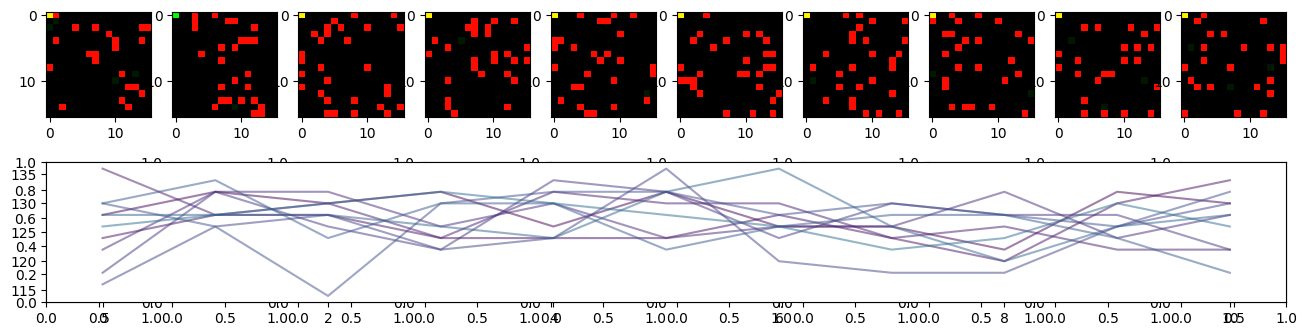

In [30]:
import math
from deepq_utils import GameEnv, select_action
from pointpainter_model import PointPainerModel
from IPython import display

BATCH_SIZE = 10
GAMMA = 0.99
EPS_START = 0.5
EPS_END = 0.01
EPS_DECAY = 5000
TAU = 0.01
LR = 1e-1
num_episodes = 500

policy_net = PointPainerModel(16).to(device)
target_net = PointPainerModel(16).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


env = GameEnv(size=SIZE, batch_size=BATCH_SIZE, mask=mask)

rewards = []

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    actions  = torch.zeros_like(env.state, dtype=torch.float)
    state = env.state
    # print("neki", state[0][0])
    for t in range(50):
        eps  = EPS_END + (EPS_START - EPS_END) * \
              math.exp(-1. * i_episode / EPS_DECAY)
        # print(f"episode {t}", state.shape, mask.shape)
        action = select_action(state, eps, policy_net, mask)
        actions += action.float()
        next_state, reward = env.step(action)
        
       
        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model(
            policy_net=policy_net,
            target_net=target_net,
            memory=memory,
            optimizer=optimizer,
            BATCH_SIZE=BATCH_SIZE,
            GAMMA=GAMMA,
        )

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
    
    env.reset()
    rw = reward.sum(dim=(1)).cpu().numpy()
    rewards.append(reward.sum(dim=(1)).cpu().numpy())
    print(rw)
    plot_state(state, actions, rewards)